In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import io

In [3]:
## Find all the tiffiles in the tif path
# File I/O is pipelined, so the data doesn't have to be on a fast SSD 
# single HDDs or reasonably fast network drives should work without much difference in speed 
tif_path = r'/mnt/md0/data/Coconut'
tifs = io.get_tif_paths(tif_path)

In [4]:
tifs = tifs[:5]

In [5]:
# Set the mandatory parameters
params = {
    # volume rate
    'fs': io.get_vol_rate(tifs[0]),
    # planes to analyze. 0 is deepest, 30 is shallowest (corrected for ScanImage channel IDs)
    # you should keep all the planes to do crosstalk estimation! 
    'planes' : n.arange(30),
    # Decay time of the Ca indicator in seconds. 1.3 for GCaMP6s. This example is for GCamP8m
    'tau' : 1.3
}

### "Job" structure
The unimaginatively named `Job` structure is meant to contain all of the parameters, data, logs, and results for a single recording. It will be created in the root directory provided with the given name. All intermediate and final results will be saved in this directory, so I recommend using a fast SSD for this (and moving results to slow HDD once processing is complete).

All the print statements you see (and more) are also logged in `<job dir>/logfile.txt`. If you want things to look cleaner, reduce the verbosity to 2 (full logs will still be in the logfile).

To load a previously created job (to do more processing or load results), set `create=False`. If `create=True` but there exists another job of the same name in the root directory, it will either overwrite the parameters of the previous job or throw an error (depending on the `overwrite` parameter). Note, overwriting isn't as catastrophic as it sounds since data isn't deleted and remains accessible, but you might lose the saved parameters and some metadata.

In [6]:
# Create the job
job = Job('/mnt/md0/runs','Full-Demo-Coconut', tifs = tifs,
          params=params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-Full-Demo-Coconut already exists
Loading job directory for Full-Demo-Coconut in /mnt/md0/runs
   Loading dirs 
      Found dir registered_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param fs
      Updating param planes
      Updating param tau
   Updated main params file


## Initial pass
This pass takes a few files (`n_init_files`, usually ~200-300 frames is enough) and does the following:
- estimates the crosstalk coefficient between the lower set of 15 planes and the higher 15 planes
- computes the shifts between successive planes caused by the xy-shift of the light beads
- estimates the optimal number of pixels that overlap between successive strips, so they can be fused together
- calculates a "reference volume" that will be used later in registration 

In [7]:
# optional parameters for initialization
# load 1 file to initialize
job.params['n_init_files'] = 1
# If set to None, use all of the frames in the loaded init files 
# if your files are really big, set this to <300
job.params['init_n_frames'] = 100

# Set to None to auto-compute the crosstalk coefficient
# You can set a float value between 0-1 (usually around 0.1-0.3) to override the calculation
job.params['override_crosstalk'] = None
# number of processors to use
job.params['n_proc_corr'] = 70
job.params['fuse_shift_override'] = 1

In [8]:
%%time
# This step only uses `n_init_files` files, so the  runtime will stay the same even with larger recordings
# soon this will also be gpu-ified to be faster!
# job.run_init_pass()

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


In [9]:
summary = job.load_summary()

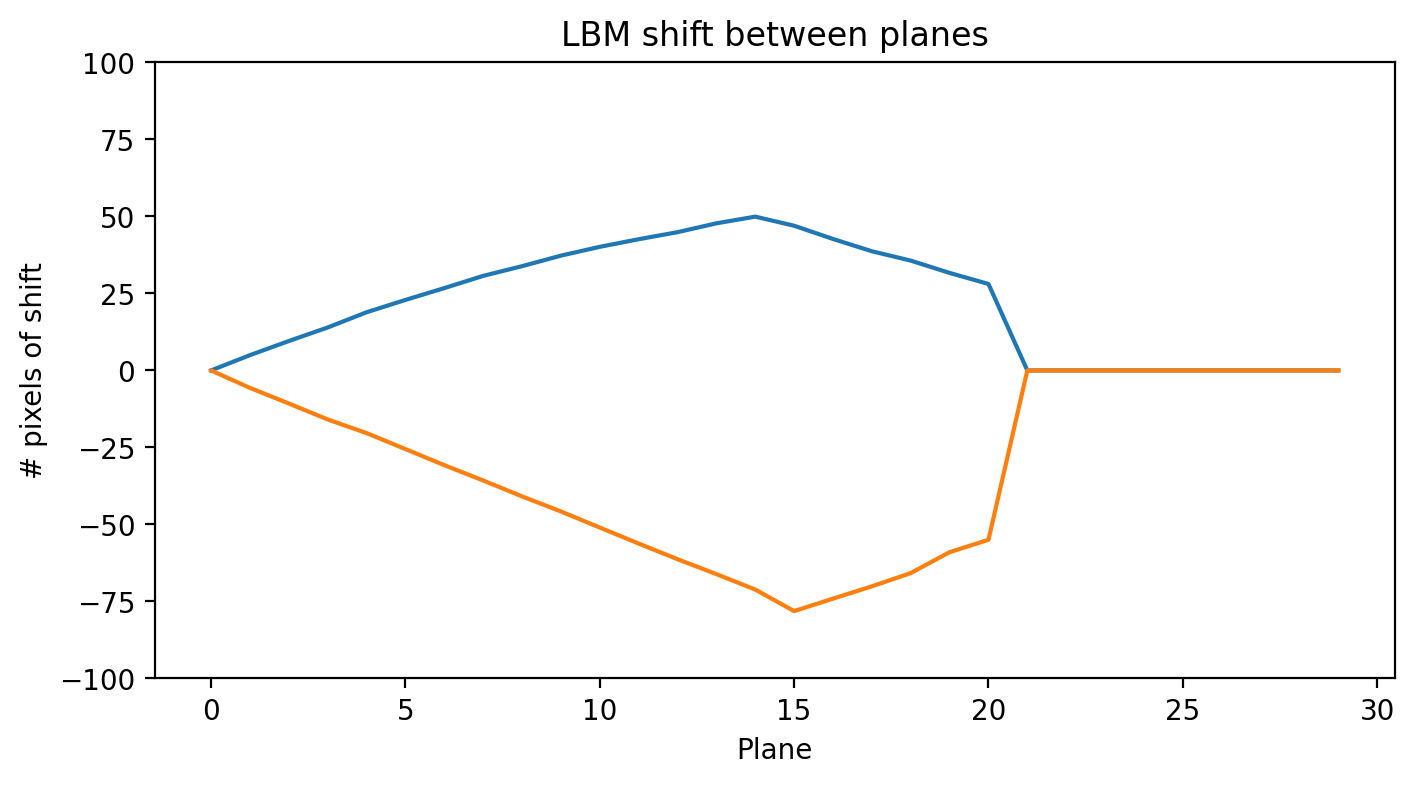

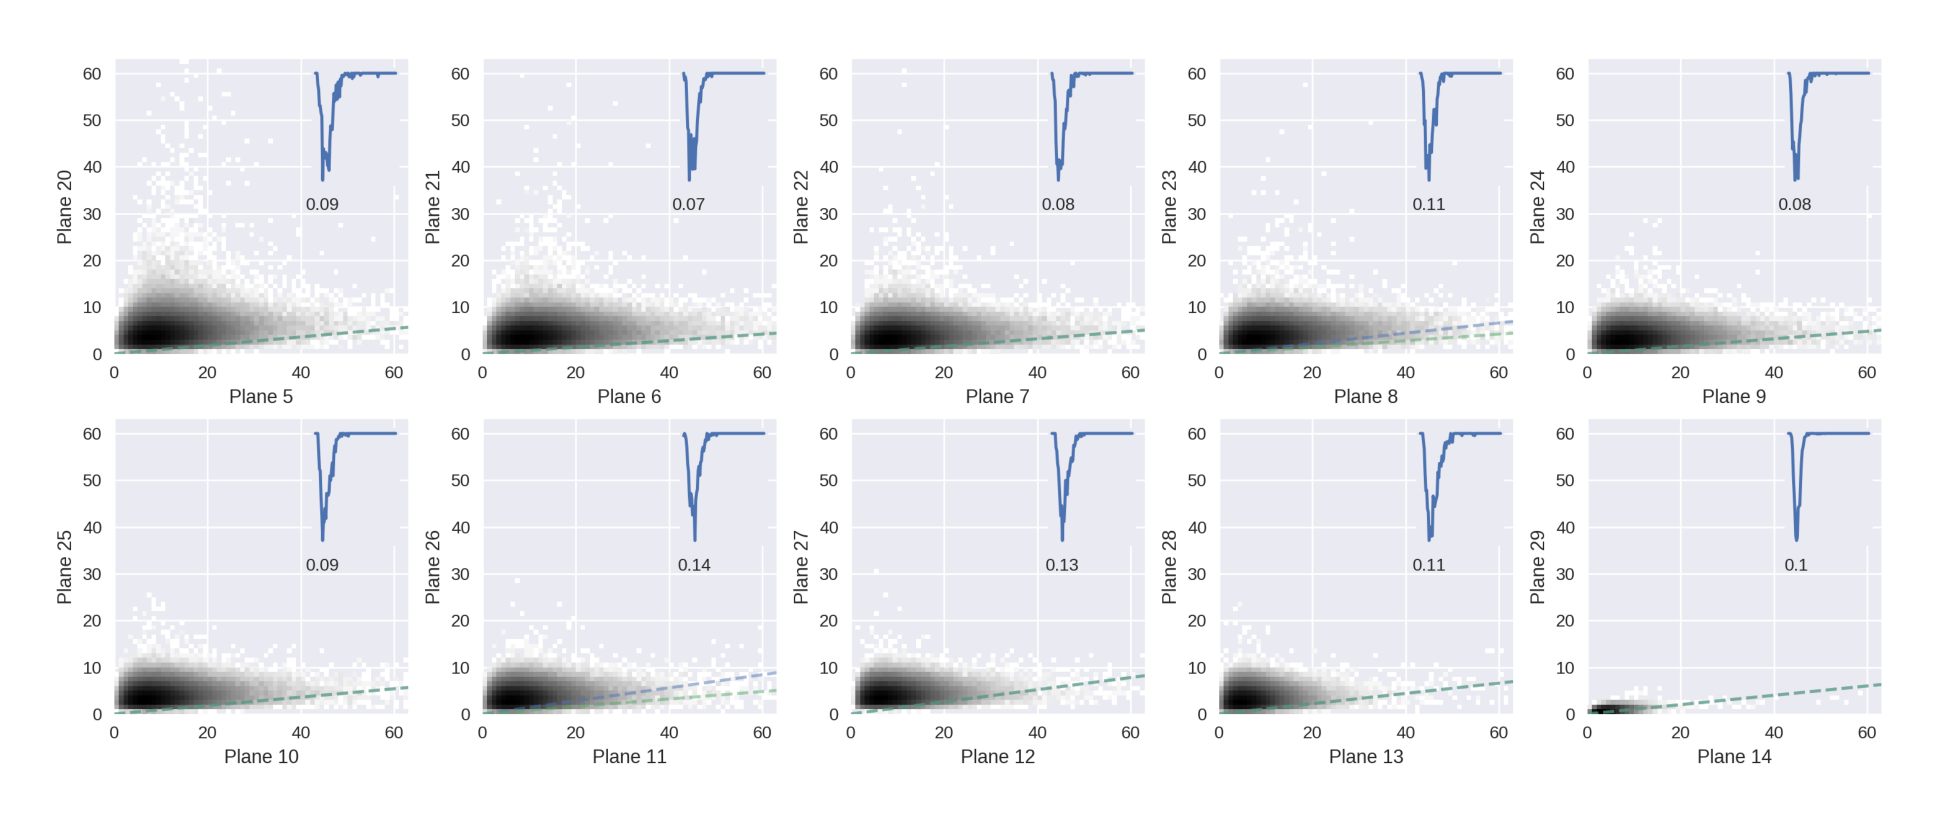

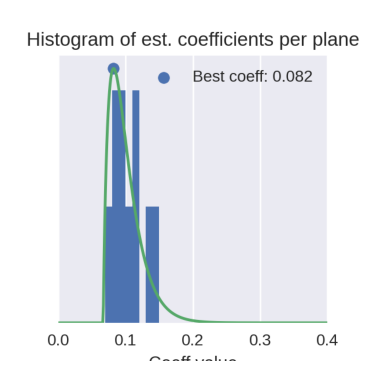

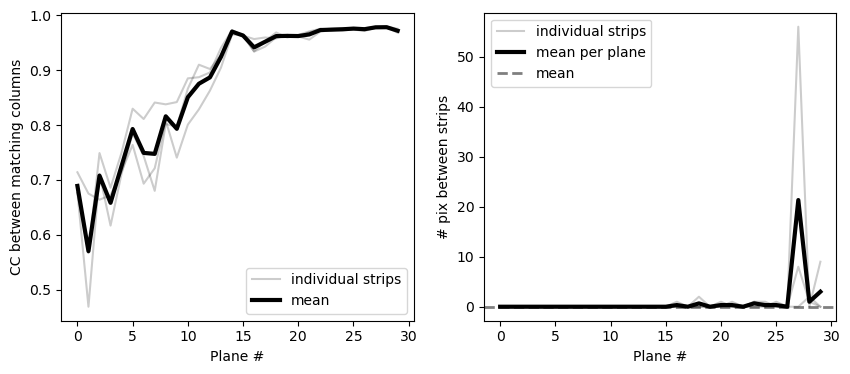

In [10]:
job.show_summary_plots()

## Registration
First, we do registration over time of the  xy-drift caused by brain movement. This is similar to Suite2P registratrion, it does rigid registration followed by non-rigid registration. This is accelerated on the GPU. Suite2P registration parameters can be changed, see `default_params.py` for a list of all parameters related to registration. After you have registered, you can load the registered fused movie into memory and take a look at the mean image. I suggest cropping the dark edges if you have any as shown in the cells below.

If you run out of gpu memory, try reducing the `gpu_reg_batchsize` parameter. I have a A4500 with 20GB memory which works well with a batchsize of 10.

In [13]:
# If you have large tiffs, split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 100
job.params['gpu_reg_batchsize'] = 10

In [14]:
%%time
job.register_gpu()

      Found dir /mnt/md0/runs/s3d-Full-Demo-Coconut/registered_fused_data with tag registered_fused_data
   Overriding fuse shift value to 1
Will analyze 5 tifs in 5 batches
   Enforcing positivity
   Launching IO thread
      Loading /mnt/md0/data/Coconut/Max30_500umdeep_1p75by1p75mm_3umppix_9p86Hz_250mW_00001_00001.tif
         Memory at batch 0.  Total Used: 209.007 GB, Virtual Available: 309.874 GB, Virtual Used: 193.322 GB, Swap Used: 015.686 GB
Loading Batch 0 of 4


<tifffile.TiffFile 'Max30_500umdeep…_00001_00001.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in a

   Loaded 1 files, total 18.79 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 227.822 GB, Virtual Available: 291.060 GB, Virtual Used: 212.136 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 246.648 GB, Virtual Available: 272.233 GB, Virtual Used: 230.963 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 227.820 GB, Virtual Available: 291.061 GB, Virtual Used: 212.135 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/md0/data/Coconut/Max30_500umdeep_1p75by1p75mm_3umppix_9p86Hz_250mW_00001_00002.tif
         After IO thread launch:Total Used: 227.820 GB, Virtual Available: 291.061 GB, Virtual Used: 212.135 GB, Swap Used: 015.686 GB
      Loaded batch of size (30, 986, 584, 584)
      Sending frames 0-10 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.50 sec
         Subtracting min pix vals to enforce positivity
       

   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.61 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.92 sec
         After GPU Batch:    Total Used: 249.783 GB, Virtual Available: 269.099 GB, Virtual Used: 234.097 GB, Swap Used: 015.686 GB
      Sending frames 70-80 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.41 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks i

<tifffile.TiffFile 'Max30_500umdeep…_00001_00002.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


   Non rigid transformed (on CPU) in 0.95 sec
         After GPU Batch:    Total Used: 256.183 GB, Virtual Available: 262.699 GB, Virtual Used: 240.497 GB, Swap Used: 015.686 GB
      Sending frames 90-100 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.41 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.6

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Non rigid transformed (on CPU) in 5.82 sec
         After GPU Batch:    Total Used: 308.398 GB, Virtual Available: 210.483 GB, Virtual Used: 292.713 GB, Swap Used: 015.686 GB
      Sending frames 160-170 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.18 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.03 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.51 sec
         Allocated GPU array for non-rigid reg in 0.12 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.

   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.61 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.94 sec
         After GPU Batch:    Total Used: 295.360 GB, Virtual Available: 223.522 GB, Virtual Used: 279.674 GB, Swap Used: 015.686 GB
      Sending frames 240-250 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.97 sec
         After GPU Batch:    Total Used: 265.552 GB, Virtual Available: 253.329 GB, Virtual Used: 249.867 GB, Swap Used: 015.686 GB
      Sending frames 320-330 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.41 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.61 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.95 sec
         After GPU Batch:    Total Used: 269.287 GB, Virtual Available: 249.594 GB, Virtual Used: 253.602 GB, Swap Used: 015.686 GB
      Sending frames 400-410 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.96 sec
         After GPU Batch:    Total Used: 273.018 GB, Virtual Available: 245.864 GB, Virtual Used: 257.332 GB, Swap Used: 015.686 GB
      Sending frames 480-490 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.94 sec
         After GPU Batch:    Total Used: 276.765 GB, Virtual Available: 242.117 GB, Virtual Used: 261.079 GB, Swap Used: 015.686 GB
      Sending frames 560-570 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.95 sec
         After GPU Batch:    Total Used: 280.517 GB, Virtual Available: 238.364 GB, Virtual Used: 264.832 GB, Swap Used: 015.686 GB
      Sending frames 640-650 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.97 sec
         After GPU Batch:    Total Used: 284.253 GB, Virtual Available: 234.628 GB, Virtual Used: 268.568 GB, Swap Used: 015.686 GB
      Sending frames 720-730 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.39 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.59 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.94 sec
         After GPU Batch:    Total Used: 287.996 GB, Virtual Available: 230.885 GB, Virtual Used: 272.311 GB, Swap Used: 015.686 GB
      Sending frames 800-810 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.39 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.59 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.94 sec
         After GPU Batch:    Total Used: 291.735 GB, Virtual Available: 227.146 GB, Virtual Used: 276.050 GB, Swap Used: 015.686 GB
      Sending frames 880-890 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.39 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.95 sec
         After GPU Batch:    Total Used: 295.473 GB, Virtual Available: 223.409 GB, Virtual Used: 279.787 GB, Swap Used: 015.686 GB
      Sending frames 960-970 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.41 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.62 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.88 sec
         After GPU Batch:    Total Used: 278.952 GB, Virtual Available: 239.929 GB, Virtual Used: 263.267 GB, Swap Used: 015.686 GB
      Sending frames 20-30 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mo

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.41 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec


<tifffile.TiffFile 'Max30_500umdeep…_00001_00003.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.61 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.92 sec
         After GPU Batch:    Total Used: 303.452 GB, Virtual Available: 215.429 GB, Virtual Used: 287.767 GB, Swap Used: 015.686 GB
      Sending frames 100-110 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Non rigid transformed (on CPU) in 12.25 sec
         After GPU Batch:    Total Used: 365.750 GB, Virtual Available: 153.132 GB, Virtual Used: 350.064 GB, Swap Used: 015.686 GB
      Sending frames 170-180 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 5.69 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.03 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 6.04 sec
         Allocated GPU array for non-rigid reg in 0.09 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 6

   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.61 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 1.96 sec
         After GPU Batch:    Total Used: 336.051 GB, Virtual Available: 182.831 GB, Virtual Used: 320.365 GB, Swap Used: 015.686 GB
      Sending frames 250-260 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.41 sec
         Allocated GPU array for non-rigid reg in 0.47 sec
   Clipped movie in 0.00 sec
   Split movie into blocks

         Registered batch in 0.03 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.48 sec
         Allocated GPU array for non-rigid reg in 0.09 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.71 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 1.13 sec
         After GPU Batch:    Total Used: 311.831 GB, Virtual Available: 207.050 GB, Virtual Used: 296.146 GB, Swap Used: 015.686 GB
      Sending frames 330-340 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.18 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.39 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.93 sec
         After GPU Batch:    Total Used: 315.559 GB, Virtual Available: 203.323 GB, Virtual Used: 299.873 GB, Swap Used: 015.686 GB
      Sending frames 410-420 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.61 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.94 sec
         After GPU Batch:    Total Used: 319.311 GB, Virtual Available: 199.570 GB, Virtual Used: 303.625 GB, Swap Used: 015.686 GB
      Sending frames 490-500 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.61 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.95 sec
         After GPU Batch:    Total Used: 323.058 GB, Virtual Available: 195.824 GB, Virtual Used: 307.372 GB, Swap Used: 015.686 GB
      Sending frames 570-580 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.93 sec
         After GPU Batch:    Total Used: 326.805 GB, Virtual Available: 192.077 GB, Virtual Used: 311.119 GB, Swap Used: 015.686 GB
      Sending frames 650-660 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.94 sec
         After GPU Batch:    Total Used: 330.550 GB, Virtual Available: 188.332 GB, Virtual Used: 314.864 GB, Swap Used: 015.686 GB
      Sending frames 730-740 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.39 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.93 sec
         After GPU Batch:    Total Used: 334.294 GB, Virtual Available: 184.588 GB, Virtual Used: 318.608 GB, Swap Used: 015.686 GB
      Sending frames 810-820 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.61 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.94 sec
         After GPU Batch:    Total Used: 338.042 GB, Virtual Available: 180.839 GB, Virtual Used: 322.357 GB, Swap Used: 015.686 GB
      Sending frames 890-900 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.92 sec
         After GPU Batch:    Total Used: 341.799 GB, Virtual Available: 177.082 GB, Virtual Used: 326.114 GB, Swap Used: 015.686 GB
      Sending frames 970-980 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.07 sec
         Shifted batch in 0.16 sec
         Freeing all blocks
      Completed rigid registration in 0.50 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.70 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.91 sec
         After GPU Batch:    Total Used: 280.736 GB, Virtual Available: 238.146 GB, Virtual Used: 265.050 GB, Swap Used: 015.686 GB
      Sending frames 30-40 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mo

<tifffile.TiffFile 'Max30_500umdeep…_00001_00004.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


   Non rigid transformed (on CPU) in 0.89 sec
         After GPU Batch:    Total Used: 302.256 GB, Virtual Available: 216.625 GB, Virtual Used: 286.571 GB, Swap Used: 015.686 GB
      Sending frames 100-110 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Loaded mov and masks to GPU for rigid reg in 9.41 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.03 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 13.45 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 13.66 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 2.47 sec
         After GPU Batch:    Total Used: 384.508 GB, Virtual Available: 134.374 GB, Virtual Used: 368.822

   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.91 sec
         After GPU Batch:    Total Used: 343.444 GB, Virtual Available: 175.438 GB, Virtual Used: 327.758 GB, Swap Used: 015.686 GB
      Sending frames 250-260 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.45 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.66 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 1.10 sec
         After GPU Batch:    Total Used: 310.757 GB, Virtual Available: 208.125 GB, Virtual Used: 295.071 GB, Swap Used: 015.686 GB
      Sending frames 330-340 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.18 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.94 sec
         After GPU Batch:    Total Used: 314.490 GB, Virtual Available: 204.391 GB, Virtual Used: 298.805 GB, Swap Used: 015.686 GB
      Sending frames 410-420 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.61 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.91 sec
         After GPU Batch:    Total Used: 318.244 GB, Virtual Available: 200.638 GB, Virtual Used: 302.558 GB, Swap Used: 015.686 GB
      Sending frames 490-500 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.41 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.61 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.92 sec
         After GPU Batch:    Total Used: 321.985 GB, Virtual Available: 196.897 GB, Virtual Used: 306.299 GB, Swap Used: 015.686 GB
      Sending frames 570-580 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.92 sec
         After GPU Batch:    Total Used: 325.729 GB, Virtual Available: 193.152 GB, Virtual Used: 310.044 GB, Swap Used: 015.686 GB
      Sending frames 650-660 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.93 sec
         After GPU Batch:    Total Used: 329.474 GB, Virtual Available: 189.407 GB, Virtual Used: 313.789 GB, Swap Used: 015.686 GB
      Sending frames 730-740 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.95 sec
         After GPU Batch:    Total Used: 333.223 GB, Virtual Available: 185.658 GB, Virtual Used: 317.538 GB, Swap Used: 015.686 GB
      Sending frames 810-820 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.95 sec
         After GPU Batch:    Total Used: 336.969 GB, Virtual Available: 181.912 GB, Virtual Used: 321.284 GB, Swap Used: 015.686 GB
      Sending frames 890-900 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.39 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.59 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.94 sec
         After GPU Batch:    Total Used: 340.710 GB, Virtual Available: 178.171 GB, Virtual Used: 325.025 GB, Swap Used: 015.686 GB
      Sending frames 970-980 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.09 sec
         Shifted batch in 0.23 sec
         Freeing all blocks
      Completed rigid registration in 0.59 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.79 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.90 sec
         After GPU Batch:    Total Used: 280.000 GB, Virtual Available: 238.882 GB, Virtual Used: 264.314 GB, Swap Used: 015.686 GB
      Sending frames 30-40 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mo

<tifffile.TiffFile 'Max30_500umdeep…_00001_00005.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


   Non rigid transformed (on CPU) in 0.89 sec
         After GPU Batch:    Total Used: 301.640 GB, Virtual Available: 217.242 GB, Virtual Used: 285.954 GB, Swap Used: 015.686 GB
      Sending frames 100-110 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.13 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Non rigid transformed (on CPU) in 14.31 sec
         After GPU Batch:    Total Used: 367.577 GB, Virtual Available: 151.305 GB, Virtual Used: 351.891 GB, Swap Used: 015.686 GB
      Sending frames 170-180 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 5.24 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.03 sec
         Shifted batch in 0.12 sec
         Freeing all blocks
      Completed rigid registration in 5.54 sec
         Allocated GPU array for non-rigid reg in 0.09 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 5

   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 1.86 sec
         After GPU Batch:    Total Used: 337.358 GB, Virtual Available: 181.523 GB, Virtual Used: 321.673 GB, Swap Used: 015.686 GB
      Sending frames 250-260 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.41 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.45 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.66 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 1.09 sec
         After GPU Batch:    Total Used: 312.051 GB, Virtual Available: 206.830 GB, Virtual Used: 296.366 GB, Swap Used: 015.686 GB
      Sending frames 330-340 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.18 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.93 sec
         After GPU Batch:    Total Used: 315.784 GB, Virtual Available: 203.098 GB, Virtual Used: 300.098 GB, Swap Used: 015.686 GB
      Sending frames 410-420 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.94 sec
         After GPU Batch:    Total Used: 319.526 GB, Virtual Available: 199.355 GB, Virtual Used: 303.841 GB, Swap Used: 015.686 GB
      Sending frames 490-500 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.93 sec
         After GPU Batch:    Total Used: 323.276 GB, Virtual Available: 195.606 GB, Virtual Used: 307.590 GB, Swap Used: 015.686 GB
      Sending frames 570-580 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.39 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.94 sec
         After GPU Batch:    Total Used: 327.015 GB, Virtual Available: 191.867 GB, Virtual Used: 311.329 GB, Swap Used: 015.686 GB
      Sending frames 650-660 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.94 sec
         After GPU Batch:    Total Used: 330.759 GB, Virtual Available: 188.122 GB, Virtual Used: 315.074 GB, Swap Used: 015.686 GB
      Sending frames 730-740 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.39 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.92 sec
         After GPU Batch:    Total Used: 334.503 GB, Virtual Available: 184.379 GB, Virtual Used: 318.817 GB, Swap Used: 015.686 GB
      Sending frames 810-820 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.61 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.95 sec
         After GPU Batch:    Total Used: 338.251 GB, Virtual Available: 180.631 GB, Virtual Used: 322.565 GB, Swap Used: 015.686 GB
      Sending frames 890-900 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.96 sec
         After GPU Batch:    Total Used: 341.994 GB, Virtual Available: 176.888 GB, Virtual Used: 326.308 GB, Swap Used: 015.686 GB
      Sending frames 970-980 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.39 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.91 sec
         After GPU Batch:    Total Used: 279.174 GB, Virtual Available: 239.707 GB, Virtual Used: 263.489 GB, Swap Used: 015.686 GB
      Sending frames 30-40 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mo

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.93 sec
         After GPU Batch:    Total Used: 282.917 GB, Virtual Available: 235.964 GB, Virtual Used: 267.232 GB, Swap Used: 015.686 GB
      Sending frames 110-120 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.92 sec
         After GPU Batch:    Total Used: 286.660 GB, Virtual Available: 232.222 GB, Virtual Used: 270.974 GB, Swap Used: 015.686 GB
      Sending frames 190-200 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.39 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.59 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.93 sec
         After GPU Batch:    Total Used: 290.403 GB, Virtual Available: 228.478 GB, Virtual Used: 274.718 GB, Swap Used: 015.686 GB
      Sending frames 270-280 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.93 sec
         After GPU Batch:    Total Used: 294.143 GB, Virtual Available: 224.738 GB, Virtual Used: 278.458 GB, Swap Used: 015.686 GB
      Sending frames 350-360 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.41 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.61 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.93 sec
         After GPU Batch:    Total Used: 297.893 GB, Virtual Available: 220.988 GB, Virtual Used: 282.208 GB, Swap Used: 015.686 GB
      Sending frames 430-440 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.39 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.59 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.93 sec
         After GPU Batch:    Total Used: 301.632 GB, Virtual Available: 217.250 GB, Virtual Used: 285.946 GB, Swap Used: 015.686 GB
      Sending frames 510-520 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.91 sec
         After GPU Batch:    Total Used: 305.377 GB, Virtual Available: 213.505 GB, Virtual Used: 289.691 GB, Swap Used: 015.686 GB
      Sending frames 590-600 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.94 sec
         After GPU Batch:    Total Used: 309.123 GB, Virtual Available: 209.759 GB, Virtual Used: 293.437 GB, Swap Used: 015.686 GB
      Sending frames 670-680 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.39 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.92 sec
         After GPU Batch:    Total Used: 312.871 GB, Virtual Available: 206.010 GB, Virtual Used: 297.185 GB, Swap Used: 015.686 GB
      Sending frames 750-760 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.40 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.60 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.94 sec
         After GPU Batch:    Total Used: 316.619 GB, Virtual Available: 202.263 GB, Virtual Used: 300.933 GB, Swap Used: 015.686 GB
      Sending frames 830-840 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

         Registered batch in 0.02 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 0.39 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.59 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.94 sec
         After GPU Batch:    Total Used: 320.366 GB, Virtual Available: 198.516 GB, Virtual Used: 304.680 GB, Swap Used: 015.686 GB
      Sending frames 910-920 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU 

      Completed rigid registration in 0.26 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.08 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.42 sec
      Transferred shifted mov of shape (6, 30, 634, 659) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 0.64 sec
         After GPU Batch:    Total Used: 323.774 GB, Virtual Available: 195.108 GB, Virtual Used: 308.088 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 323.774 GB, Virtual Available: 195.108 GB, Virtual Used: 308.088 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (30, 100, 634, 659) to /mnt/md0/runs/s3d-Full-Demo-Coconut/registered_fused_data/fused_reg_data0040.npy
         Saved in 20.

In [15]:
offsets = job.load_registration_results()

In [16]:
mov_full = job.get_registered_movie('registered_fused_data','f')
im_full = mov_full[:,:300].mean(axis=1).compute()

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f8bca8723a0>)

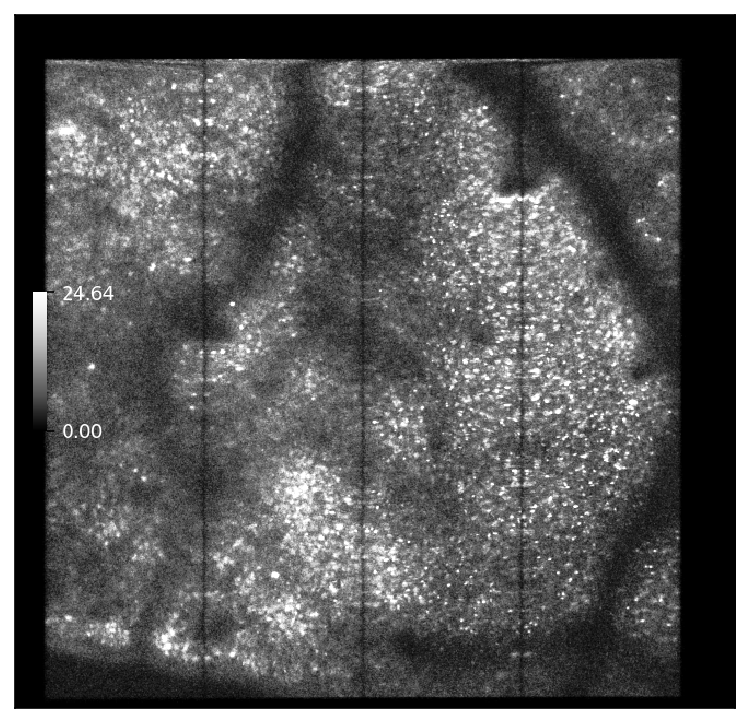

In [17]:
io.show_tif(im_full[10], cbar=True, cbar_fontcolor='w')

In [ ]:
# find crop values that minimize dark zones - check planes 0 and 15 in the following cell to 
# make sure you're not cutting out parts of the brain
# crop = ((0,18), (100,500), (100, 500))
crop = ((0,18), (None,None), (None, None))

In [ ]:
f,ax,__  = io.show_tif(im_full[0,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
# io.show_tif(im_full[15,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
ax.axis('off')

In [ ]:
f,ax,__  = io.show_tif(im_full[3,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
# io.show_tif(im_full[15,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
ax.axis('off')

In [ ]:
f,ax,__  = io.show_tif(im_full[18,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
# io.show_tif(im_full[15,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
ax.axis('off')

In [ ]:
f,ax,__  = io.show_tif(im_full[15,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
# io.show_tif(im_full[15,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
ax.axis('off')